## 1. 예측 모델에 대한 개발 설명 

저희의 모델은 기본적으로 lightgbm을 이용한 regression과 classification을 동시에 진행을 하였습니다. 기본적인 예측치를 회귀로 진행을 해준 다음, 분류에 따라 장기투자자라고 예측을 할수록 hold_d값에 가중치를 부여하는 방식으로 진행을 하였습니다.

코드 설명을 하기 앞서 저희팀은 우선 test_data의 분포가 다소 train_data의 분포와는 다를 것이라 예측하였습니다. train_data의 경우는 주식을 홀딩하고 있는 시점이 다양하지만, test_data의 경우는, 2020년까지 홀딩하고 있다가 2021년에 매도를 한 고객들의 hold값이 모여져 있습니다. 그렇기에 train data보다 test data내의 hold_d의 값이 평균적으로 클 것이라고 예측을 하였습니다.

개발환경은 다음과 같습니다. / 게시물로 보실 경우 안 보이실 수 있습니다. 다운로드를 하셔야합니다.
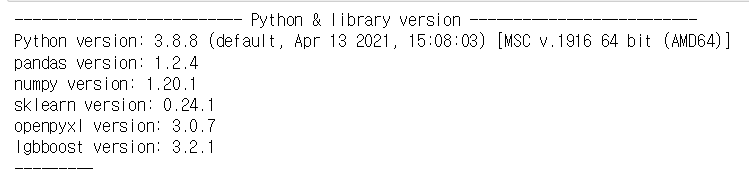

In [1]:
#데이터를 불러오는 과정 및  패키지 설치
# 아마 몇개 다운받아야할텐데 제가 일일히 적어놓지는 못했습니다. 혹시 다운해야할것이 있으면 말씀부탁드립니다.

%pip install lightgbm
%pip install pandas-datareader
%pip install openpyxl
%pip install sklearn
import pandas as pd
import numpy as np
import openpyxl
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error ,confusion_matrix
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.decomposition import PCA


pd.set_option("display.max_row", 100)
pd.set_option("display.max_column", 100)



cus = pd.read_csv("cus_info.csv")

iem = pd.read_csv("iem_info_20210902.csv")
hist = pd.read_csv("stk_bnc_hist.csv")
train = pd.read_csv("stk_hld_train.csv")
test = pd.read_csv("stk_hld_test.csv")


submission = pd.read_csv("sample_submission.csv")


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached sklearn-0.0.tar.gz (1.1 kB)
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=884948fe2e6344db7d7354c0b9f30f8ab4feed484702bac4deda34de319ceec8
  Stored in directory: c:\users\sosck\appdata\local\pip\cache\wheels\22\0b\40\fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built sklearn
Note: you may need to restart the kernel to use updated packages.


train_data의 hist_d가 주어지지 않아 hist_d의 분포가 가장 가까울 수 있는 hold_d의 분포를 확인하였습니다. 결과는 다음과 같이 기본적으로 개인투자자들은 단기투자가 많지만, test_data의 경우 좀 더 넓게 hist_d 데이터가 분포함을 알 수 있습니다. 이는 기존 가설인 train_data의 분포와 test_data의 분포가 어느정도 다름을 나타내고 있음을 알 수 있습니다. 이는 곧 train_data를 그대로 학습시킨뒤 test_data로 예측을 할 경우, 예측이 잘 안될 것을 암시하였습니다. 저희는 위와같이 train_data와 test_data의 분포가 다르다는 것을 감안하여 여러조치를 취하였습니다.
(세부 내용은 모델을 설명하면서 설명드리겠습니다.)



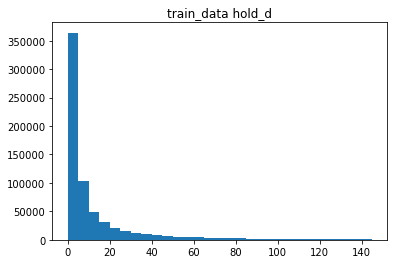

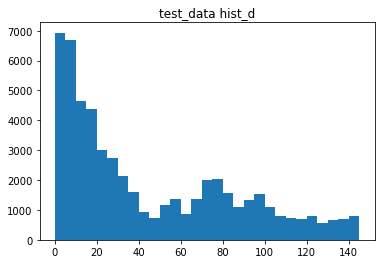

In [2]:
plt.hist(train['hold_d'],np.arange(0,146,5))
plt.title("train_data hold_d")
plt.show()

plt.hist(test['hist_d'],np.arange(0,146,5))
plt.title("test_data hist_d")
plt.show()


다른 한가지의 문제점은 바로 train_data의 hist_d의 부재입니다. hist_d는 연속되는 시점에서 어느 한 시점을 나타내주는 것으로 해석할 수 있습니다. test_data의 경우는 hist_d가 전부 20년 12월 31일로 고정이 되어있지만, train_data의 경우는 16년에서 20년 사이의 매도 데이터이므로 시점을 특정 한 시점으로 고정하기는 어렵습니다. 만약 비슷한 시점으로 19년 12월 31일까지를 hist_d로 시점을 고정시키고 20년에 매도한 데이터를 관찰할 경우는 train_data의 수가 급격히 적어져 오히려 underfitting의 문제가 발생할 가능성이 높았습니다.

그렇기에 저희는 시점을 특정한 시점에 고정시키지 않고 random값을 이용하여 hold값과 0사이의 random하게 값을 추출하여 hist_d로 놓는 과정을 거쳤습니다. 이는 시점이 고정되어 있지 않아 보다 폭넓은 dataset에 활용을 할 수 있으며, hist_d의 특성(오래 주식을 보유한 사람일수록 이후에 오래 들고 있을 가능성이 높음)을 잘 표현해주는 변수라고 판단하였습니다.

데이터의 train값이 약간은 달라질 수 있지만, 이는 많은 데이터를 확보할 수 있기에 더욱 낮은 오차를 보였습니다.

In [3]:
# 랜덤으로 hist_d를 추출 / 5개의 랜덤값을 추출한 뒤 choice 과정을 한번 더 거쳐 
# random 함수의 약간의 규칙성 역시 최대한 배제하게끔 설정하였습니다.

random_list=list()
for i in train['hold_d']:
    
    z=i
    rand_list=list()

    for k in range(5):
        rand=random.randint(1,float(i))
    
        rand_list.append(rand)
    randoms=random.choice(rand_list)
    random_list.append(randoms)
train['hist_d']=pd.DataFrame(random_list)





저희팀은 고객이 매수한 주식의 16년부터 20년까지의 평균 주간수익률과 평균 주간 변동성을 구하여 csv파일로 저장을 하였습니다.('NH_std_list.csv')
이 데이터들은 어느정도 변동성 클수록 또는 수익률 음의 방향으로 큰 주식일수록 투자자가 손실을 볼 가능성이 높을 것입니다. 이러한 종목들을 매수한 고객들이 더욱 오래들고 있을 경향을 반영하기 위함입니다. 이러한 가설로 영향력이 기존 train_data의 변수들보다 예측력이 높을 것이라고 판단하였습니다.

다만, 이 데이터의 단점은 train_data의 보유시점은 각기 다양하지만 16년부터 20년까지로 주식 평균 수익률이 고정되어 있다는 점입니다. 저희팀 역시 이러한 점때문에 train_daa에 과적합을 우려가 있습니다. 뿐만 아니라, 고객들의 시점에 상관없이 수익률 평균치를 입력하므로 불순도가 높은 변수입니다. 이는 차후 고객별 개인 수익률데이터를 이용할 수 있다면, 교체해 사용하는 것이 더욱 바람직하다고 판단하였습니다.

In [4]:
#주식별 5년치 수익률과 변동성을 딕셔너리 형태로 변환, 이후 train 및 test데이터에 병합을 할 예정입니다.
std = pd.read_csv('https://raw.githubusercontent.com/wonsikd/NH_code/main/NH_std_list.csv')
std_dict=std.set_index("Ticker")["변동성"].to_dict()
pro_dict=std.set_index("Ticker")["평균 주간 수익률"].to_dict()

기본적인 데이터 정제는 데이콘 lightgbm을 이용한 베이스라인 코드에 제시되어 있는 전처리 코드를 기초로 하였습니다.

출처 : https://dacon.io/competitions/official/235798/codeshare/3155?page=1&dtype=recent

In [5]:
#데이콘 베이스라인 코드를 기반으로 제작하였습니다.

# hold_d값에서 랜덤으로 구한 hist_d값을 빼준 새로운 hold_d를 산출합니다.

train["hold_d"]=train["hold_d"]-train["hist_d"]
train.hist_d = np.trunc(train["hist_d"])

#각종 data들을 ID를 기반으로 병합시킵니다.

train_data = pd.merge(train, cus, how = "left", on = ["act_id"])
train_data = pd.merge(train_data, iem, how = "left", on = ["iem_cd"])

test_data = pd.merge(test, cus, how = "left", on = ["act_id"])
test_data = pd.merge(test_data, iem, how = "left", on = ["iem_cd"])

#y_label을 따로 변수로 저장했습니다.
train_label = train_data["hold_d"]

# hist 값의 결측치는 0으로 표기하게끔 하였습니다.

hist["stk_p"] = hist["tot_aet_amt"] / hist["bnc_qty"]
hist = hist.fillna(0)

train_data = pd.merge(train_data, hist, how = "left", on = ["act_id", "iem_cd"])
train_data = train_data[(train_data["byn_dt"] == train_data["bse_dt"])]
train_data.reset_index(drop = True, inplace = True)

test_data = pd.merge(test_data, hist, how = "left", on = ["act_id", "iem_cd"])
test_data = test_data[(test_data["byn_dt"] == test_data["bse_dt"])]
test_data.reset_index(drop = True, inplace = True)

stock_code_frame=train_data['iem_cd']

L_encoder = LabelEncoder()
L_encoder.fit(iem["iem_krl_nm"])
train_data["iem_krl_nm"] = L_encoder.transform(train_data["iem_krl_nm"])
test_data["iem_krl_nm"] = L_encoder.transform(test_data["iem_krl_nm"])

train_data.reset_index(drop = True, inplace=True)
train_label.reset_index(drop = True, inplace=True)

-hist_d의 평균을 통해 hold_d 평균 유추

밑의 과정들은 위에서 언급한 train_data와 test_data의 분포가 다른 것을 보완하기 위해 추가적으로 보완해주는 과정입니다.
test_data의 hold_d값을 알 수가 없으므로 저희는 hold_d대신에 hold_d에 영향력이 높은 hist_d의 평균치로 hold_d값을 유추하기로 결정하였습니다.

밑의 값에서 알 수 있듯이, train data의 평균적인 hist_d는 22.3 정도입니다. 이는 hist_d가 random함수임에도 어느정도 일정하게 유지되는 것을 확인하였습니다.
반면에 test_data에서의 평균 hist_d값은 상대적으로 높은 113.2가 나왔습니다. 이 분석결과는 hist_d를 통해 hold_d가 train 보다는 test 평균치가 더욱 높을 것임을 암시해줍니다.
이를 예방하기 위해 train_data의 hist_d값을 평균적으로 113 근처로 맞춰줘 hold_d값이 어느정도 변화하는지를 관찰하였습니다.

In [6]:
print('train_data의 hist_d 평균 :',np.average(train_data['hist_d']))
print('test_data의 hist_d 평균 :',np.average(test_data['hist_d']))

train_data의 hist_d 평균 : 10.293620280803907
test_data의 hist_d 평균 : 113.24084933990595


분포를 정확히 일치하게끔 data를 전처리하기는 어려우므로 최솟값을 올려가며 hist_d의 평균값이 110 - 113이 되게끔 반복문을 실행해주었다.
그리고 그때의 hold_d의 평균을 high_avg라고 저장하였다. 또한, test_data의 hold_d값이 0 - 146임을 감안하여 필터링을 해주었으며,
지나치게 1~3일에 몰려있는 단기적인 홀딩값들은 장기적인 test_data의 분포를 예측하는데 적합하지 않다고 판단해 3일 이상인 값들만 필터링해주었다.


In [7]:
# hist_d의 최솟값을 올려가며 hold_d의 평균 관찰

for k in range(30,100):
    is_hist_data = train_data['hold_d']<146 #3이 좋았음
    is_hist_data1 = train_data['hold_d']>3
    hist_data =  train_data.loc[is_hist_data&is_hist_data1]

    hist_data=hist_data.reset_index(drop=True)
    is_hist_data = hist_data['hist_d']>k #3이 좋았음
    
    hist_data =  hist_data.loc[is_hist_data]
    high_avg=np.average(hist_data['hist_d'])
    if high_avg>110 and high_avg<113:
        high_avg=np.average(hist_data['hold_d'])
        print(high_avg)
        break
    


43.084287493471535


In [8]:
#hist_d의 평균이 대략 110일때 hold_d의 평균이다.
high_avg

43.084287493471535

hist_d의 평균이 113정도일때 평균적인 hold_d 값이 43정도로 나오는 것을 알 수 있습니다. 이는 밑에 과정에서 구하는 train_data의 평균적인 hold_d값(avg1)과 차이가 있음을 알 수 있습니다. 학습시킬 데이터의 평균적인 hold_d값은 21정도가 나오며 이는 평균적으로 20일 만큼 더욱 큽니다.
이러한 데이터 분석 결과는 비록 정확한 test_data의 분포를 구하지 못하였지만 어느 정도 test_data의 평균이 편향되어 있음을 유추 해볼 수 있습니다.
그렇기에 저희팀은 train_data를 학습시킨 모델에 test_data를 적용시킬때에 high_avg -avg1 만큼의 값을 전체적으로 더해주기로 결정하였습니다.

In [9]:
#다음은 실제 트레인할 데이터을 필터링 해주고 트레인하는 데이터의 평균(avg1)이 어느정도인지 관찰하는 코드이다. 이후 avg1과 high_avg의 차이가
# 평균적으로 test_data의 편향을 줄여줄 것이므로 high_avg - avg1을 전체 데이터셋에 더해줄 것이다.
# test_data 분포 특성상 단기보유일의 비율이 상대적으로 적어지므로 더욱 잘 예측하기 위해 위와 동일하게 hold_d값을 3일에서 146일로 고정시켰다.
is_hist_data = train_data['hold_d']<146 
is_hist_data1 = train_data['hold_d']>3
hist_data =  train_data.loc[is_hist_data&is_hist_data1]

hist_data=hist_data.reset_index(drop=True)
is_hist_data = hist_data['hist_d']>0 
hist_data =  hist_data.loc[is_hist_data]
avg1=np.average(hist_data['hold_d'])
print('학습시킬 데이터의 hold_d의 평균 : ',avg1)

hist_data=hist_data.reset_index(drop=True)

학습시킬 데이터의 hold_d의 평균 :  20.68379963769158


In [10]:
#이 과정은 데이터별 종목에 대한 5년간 주간수익률 및 변동성의 평균치를 넣어주는 과정입니다. 아이디별로 반복문을 실행시켜주었습니다.
std_list=[]
pro_list=[]
for i in train_data['iem_cd']:
    std_list.append(std_dict[i])
    pro_list.append(pro_dict[i])

std_list1=[]
pro_list1=[]
for i in test_data['iem_cd']:
    
    std_list1.append(std_dict[i])
    pro_list1.append(pro_dict[i])
    
hist_data["stock_std"]=pd.DataFrame(std_list)
hist_data["stock_profit"]=pd.DataFrame(pro_list)
test_data["stock_std"]=pd.DataFrame(std_list1)
test_data["stock_profit"]=pd.DataFrame(pro_list1)


다음으로는 고객마다 평균적인 hold_d값을 avg_d로 저장하게끔 하였습니다. 매수일 전에 존재하는 hold_d값을 바탕으로 평균치를 구해주는 과정이므로 데이터를 전처리하는데 시간이 많이 걸려 제가 따로 실행을 해서 파일로 저장을 해두었습니다. 이외에도 고객의 거래일 이전의 거래횟수와 hold_d의 표준편차를 구해보았습니다.(변수명 : cus_count->거래일 이전 거래횟수, cus_std -> 거래일 이전 표준편차)
hist_d값 자체가 랜덤변수라 새롭게 돌리면 값이 전체적으로 약간씩은 변하지만, 오차값의 차이는 크게 없으며 전체적으로 모델의 학습은 더욱 좋아졌습니다. 만약 데이터를 새로 받으시고 싶으면 주석을 제거해서 사용하시길 바랍니다.

In [11]:
#트레인 데이터에 avg_d넣는 과정입니다. avg_d는 산 날짜 이전에 고객이 평균적인 hold_d값이라고 생각하면 된다. 구하는데 시간이 많이 걸려
# 미리 저장하였습니다. (hist_train_data_1.csv) 파일 하나를 두개로 나눠서 깃허브에 업로드 하였습니다.
'''
hd_list=[]
hd_list_std=[]
hd_list_count=[]
hist_data1=hist_data[['act_id','byn_dt','hold_d']]
hist_data2=train_data[['act_id','byn_dt','hold_d']]
for index,i in enumerate(hist_data1['act_id']):
    print(index)
    buy_day=hist_data1['byn_dt']
    day=buy_day.loc[index]
    train_buy_day=hist_data2['byn_dt']
    #print(day)
    id_data=hist_data2[(hist_data2['act_id']==i) & (train_buy_day<day)]
    #print(id_data)
    #print(i,"/",day)
    #print(id_data)
    if len(id_data['hold_d'])==0:
            hd_list.append(0)
            hd_list_std.append(0)
            hd_list_count.append(0)
            
            print(0)
            continue
    print(np.average(id_data['hold_d']))
    
    hd_list.append(np.average(id_data['hold_d']))
    hd_list_std.append(len(id_data['hold_d']))
    hd_list_count.append(np.std(id_data['hold_d']))

hist_data["avg_d"]=pd.DataFrame(hd_list)
hist_data["cus_std"]=pd.DataFrame(hd_list_std)
hist_data["cus_count"]=pd.DataFrame(hd_list_count)
hist_data.to_csv('hist_data_train_1.csv')
'''

'\nhd_list=[]\nhd_list_std=[]\nhd_list_count=[]\nhist_data1=hist_data[[\'act_id\',\'byn_dt\',\'hold_d\']]\nhist_data2=train_data[[\'act_id\',\'byn_dt\',\'hold_d\']]\nfor index,i in enumerate(hist_data1[\'act_id\']):\n    print(index)\n    buy_day=hist_data1[\'byn_dt\']\n    day=buy_day.loc[index]\n    train_buy_day=hist_data2[\'byn_dt\']\n    #print(day)\n    id_data=hist_data2[(hist_data2[\'act_id\']==i) & (train_buy_day<day)]\n    #print(id_data)\n    #print(i,"/",day)\n    #print(id_data)\n    if len(id_data[\'hold_d\'])==0:\n            hd_list.append(0)\n            hd_list_std.append(0)\n            hd_list_count.append(0)\n            \n            print(0)\n            continue\n    print(np.average(id_data[\'hold_d\']))\n    \n    hd_list.append(np.average(id_data[\'hold_d\']))\n    hd_list_std.append(len(id_data[\'hold_d\']))\n    hd_list_count.append(np.std(id_data[\'hold_d\']))\n\nhist_data["avg_d"]=pd.DataFrame(hd_list)\nhist_data["cus_std"]=pd.DataFrame(hd_list_std)\nhist

밑의 코드는 저장되어있는 train_data를 불러오는 과정입니다. avg_d ,cus_count, cus_std를 구하는데 시간이 많이 소요될 수 있어서 파일을 불러오게끔 하였으며, 변수들을 받아오시고 싶으실 경우는 위의 주석처리를 제거하시면 되겠습니다.

In [12]:
#우선 hist_data로 변수를 저장한뒤 여러 전처리과정을 거친뒤에 train_data로 변수를 변환시킬 예정입니다.

hist_data1=pd.read_csv('https://raw.githubusercontent.com/wonsikd/NH_code/main/random_data_1.csv')

hist_data2=pd.read_csv('https://raw.githubusercontent.com/wonsikd/NH_code/main/random_data_2.csv')
hist_data=pd.concat([hist_data1,hist_data2],axis=1)
hist_data=hist_data.drop(['Unnamed: 0'],axis=1)


다음은 test_data의 avg_d와 cus_count, cus_std를 첨가하는 과정입니다. test_data의 경우는 20년 12월 31일에 관측하는 값들이므로 train_data의 전체적인 data를 아이디별로 그룹화 하여 값들을 도출하였습니다.

In [ ]:
#딕셔너리 형태로 저장하여 테스트데이터의 avg_d cus_std cus_count 변수를 추가해주었습니다.

group=train.groupby('act_id').mean()
group=group.reset_index()
group=group[["act_id","hold_d"]]
id_list=group["act_id"].to_list()
group=group.set_index('act_id')
dict_avg=group["hold_d"].to_dict()

group=train.groupby('act_id').count()
group=group.reset_index()
group=group[["act_id","hold_d"]]
id_list=group["act_id"].to_list()
group=group.set_index('act_id')
dict_count=group["hold_d"].to_dict()

group=train.groupby('act_id').std()
group=group.reset_index()
group=group[["act_id","hold_d"]]
id_list=group["act_id"].to_list()
group=group.set_index('act_id')
dict_std=group["hold_d"].to_dict()

#만약 해당 아이디가 트레인데이터에 존재하지 않는다면 0으로 표기되게끔 하였습니다.

hd_list=[]
hd_list_std=[]
hd_list_count=[]
for index,i in enumerate(test_data['act_id']):
    print(index)
    if i in id_list:
        
        
        hd_list.append(dict_avg[i])
        hd_list_std.append(dict_std[i])
        hd_list_count.append(dict_count[i])
    else:
        hd_list.append(0)
        hd_list_count.append(0)
        hd_list_std.append(0)
        


test_data["avg_d"]=pd.DataFrame(hd_list)
test_data["cus_std"]=pd.DataFrame(hd_list_std)
test_data["cus_count"]=pd.DataFrame(hd_list_count)

In [14]:
#수익률 데이터를 사용하기 위해 종목코드에서 'A'를 제거해주는 과정입니다.(A505930 -> 505930)
ID=[]
for i in hist_data['iem_cd']:
    i=i[1:]
    ID.append(i)
hist_data['iem_cd']=pd.DataFrame(ID)

ID=[]
for i in test_data['iem_cd']:
    i=i[1:]
    ID.append(i)
test_data['iem_cd']=pd.DataFrame(ID)

In [15]:
hist_data

,act_id,iem_cd,byn_dt,hold_d,hist_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bse_dt,bnc_qty,tot_aet_amt,stk_par_pr,stk_p,stock_std,stock_profit,avg_d,cus_count,cus_std
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,005930,20180131,71,9,1,9,3,2,2,9,5,5,8,1361,9,1,1,20180131,2,4990000,5000,2495000,0.230240,0.004015,29.111111,9,33.603718
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,003520,20201112,11,11,1,9,3,2,2,9,5,5,8,1969,8,2,1,20201112,60,462000,500,7700,0.231616,0.005501,15.806452,93,36.424397
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,002230,20180806,51,47,1,9,3,2,2,9,5,5,8,2762,10,3,99,20180806,700,4039000,500,5770,0.575979,0.012699,8.656716,67,18.159782
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,000400,20200512,10,12,1,9,3,2,2,9,5,5,8,1112,2,2,99,20200512,500,945000,1000,1890,0.325118,0.009072,16.122222,90,36.981625
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,234300,20180529,7,4,1,9,3,2,2,9,5,5,8,1819,13,3,99,20180529,171,4044150,500,23650,0.282286,0.004671,8.186441,59,18.561373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209116,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,126640,20160518,4,3,1,4,4,2,2,3,4,3,8,3029,10,3,99,20160518,10253,15789620,100,1540,0.954588,0.014535,0.000000,0,0.000000
209117,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,134580,20170215,16,26,1,4,4,2,2,3,4,3,8,1061,13,3,99,20170215,1480,5860800,500,3960,0.954588,0.014535,12.200000,15,29.308019
209118,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,156100,20170413,26,38,1,4,4,2,2,3,4,3,8,1936,10,2,99,20170413,578,4901440,500,8480,0.954588,0.014535,12.437500,16,28.392272
209119,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,185750,20201124,6,6,1,4,4,2,2,3,4,3,8,2371,8,2,1,20201124,66,10692000,2500,162000,0.954588,0.014535,2.073333,150,10.269759


In [16]:
#각 계좌별 수익률을 가져오는 코드입니다. price_data_daily_1.csv 파일은 블룸버그 터미널을 이용하여 데이터를 가져와보았습니다. 
#원래는 파일을 하나로 저장이 가능한데 파일용량이 너무 커서 깃허브에 올리기 어려워 파일을 두개로 나눠서 저장한뒤 업로드를 하였습니다.
#두개의 파일을 깃허브에서 불러온 뒤 병합을 해주었습니다.
#자세한 데이터 요청 코드는 모델 설명서에 명시되어 있습니다.


data1=pd.read_csv("https://raw.githubusercontent.com/wonsikd/NH_code/main/price_data_daily_1.csv")

data2=pd.read_csv("https://raw.githubusercontent.com/wonsikd/NH_code/main/price_data_daily_2.csv")
data1=pd.concat([data1,data2],axis=1)

ID=[]
for i in data1['ID']:
    i=str(i[1:])
    ID.append(i)
data1['ID']=pd.DataFrame(ID)

In [17]:
data1

,ID,20160104,20160105,20160106,20160107,20160108,20160109,20160110,20160111,20160112,20160113,20160114,20160115,20160116,20160117,20160118,20160119,20160120,20160121,20160122,20160123,20160124,20160125,20160126,20160127,20160128,20160129,20160130,20160131,20160201,20160202,20160203,20160204,20160205,20160206,20160207,20160208,20160209,20160210,20160211,20160212,20160213,20160214,20160215,20160216,20160217,20160218,20160219,20160220,20160221,...,20201112,20201113,20201114,20201115,20201116,20201117,20201118,20201119,20201120,20201121,20201122,20201123,20201124,20201125,20201126,20201127,20201128,20201129,20201130,20201201,20201202,20201203,20201204,20201205,20201206,20201207,20201208,20201209,20201210,20201211,20201212,20201213,20201214,20201215,20201216,20201217,20201218,20201219,20201220,20201221,20201222,20201223,20201224,20201225,20201226,20201227,20201228,20201229,20201230,20201231
0,000020,7598.698190,7645.373241,7981.433603,7822.738432,8186.803824,8186.803824,8186.803824,8756.239438,8420.179076,8196.138834,8130.793764,7888.083502,7888.083502,7888.083502,8056.113683,8214.808854,8084.118713,8140.128774,8093.453724,8093.453724,8093.453724,8382.839035,8485.524146,8149.463784,8214.808854,8476.189136,8476.189136,8476.189136,8784.244468,8550.869217,8877.594569,8597.544267,8877.594569,8877.594569,8877.594569,8877.594569,8877.594569,8877.594569,8037.443663,7197.292758,7197.292758,7197.292758,7496.013080,7505.348090,7337.317909,7346.652919,7299.977868,7299.977868,7299.977868,...,17776.76455,18271.93905,18271.93905,18271.93905,18569.04375,17776.76455,17875.79945,18420.4914,19113.73570,19113.73570,19113.73570,18420.49140,20797.32900,19658.42765,19559.39275,19311.80550,19311.80550,19311.80550,18965.18335,19608.91020,19559.39275,18965.18335,18816.63100,18816.63100,18816.63100,18866.14845,18420.49140,17826.28200,17826.28200,18271.93905,18271.93905,18271.93905,19361.32295,19509.87530,19014.70080,18717.59610,20252.63705,20252.63705,20252.63705,23223.68405,23669.34110,20252.63705,19806.98000,19806.98000,19806.98000,19806.98000,18470.00885,19150.00000,19650.00000,19650.00000
1,000080,19235.351340,19910.275940,19994.641520,22399.060440,23200.533410,23200.533410,23200.533410,23537.995710,23622.361290,23580.178500,23580.178500,23284.898990,23284.898990,23284.898990,23031.802260,24339.468690,24592.565410,23833.275230,23453.630140,23453.630140,23453.630140,23748.909650,23327.081770,23580.178500,24845.662140,25098.758870,25098.758870,25098.758870,25858.049060,25942.414630,26068.963000,25267.490020,25942.414630,25942.414630,25942.414630,25942.414630,25942.414630,25942.414630,26195.511360,25815.866270,25815.866270,25815.866270,26153.328570,26406.425300,25815.866270,26153.328570,25478.403960,25478.403960,25478.403960,...,33941.85400,32720.92400,32720.92400,32720.92400,33404.64480,32818.59840,32965.11000,32720.9240,32916.27280,32916.27280,32916.27280,32720.92400,32183.71480,31890.69160,31841.85440,31695.34280,31695.34280,31695.34280,31206.97080,31109.29640,30572.08720,31646.50560,31060.45920,31060.45920,31060.45920,30767.43600,30572.08720,30620.92440,32232.55200,31939.52880,31939.52880,31939.52880,31451.15680,31158.13360,31255.80800,31060.45920,31353.48240,31353.48240,31353.48240,31304.64520,30865.11040,30718.59880,30913.94760,30913.94760,30913.94760,30913.94760,31499.99400,32000.00000,31850.00000,31850.00000
2,000180,3234.680900,3274.553700,3294.490100,3229.696800,3169.887600,3169.887600,3169.887600,4116.866600,3807.852400,3977.311800,3937.439000,3777.947800,3777.947800,3777.947800,3792.900100,3827.788800,3777.947800,3837.757000,3967.343600,3967.343600,3967.343600,4101.914300,4012.200500,4007.216400,3987.280000,3977.311800,3977.311800,3977.311800,3812.836500,3887.598000,3802.868300,3842.741100,3738.075000,3738.075000,3738.075000,3738.075000,3738.075000,3738.075000,3638.393000,3309.442400,3309.442400,3309.442400,3444.013100,3463.949500,3344.331100,3498.838200,3628.424800,3628.424800,3628.424800,...,1975.00000,1960.00000,1960.00000,1960.00000,1985.00

In [ ]:

col_list=data1.columns.tolist()

price_list=[] #팔때의 가격이 담길 리스트
price_list_1=[] #살때의 가격이 담길 리스트
k=0
for z,i in zip(hist_data["iem_cd"],hist_data["byn_dt"]):
    print(k)
    
    is_data= data1["ID"]==z
    num=hist_data.loc[k,"hist_d"]
    k=k+1
    #데이터를 불러오는 과정에서 오류가 날 경우 0을 추가하게끔 해주었습니다.
    #print(z,i,col_list.index(str(i))+num)
    if len(data1[is_data])==0:
        price_list.append(0)
        price_list_1.append(0)
        
        continue
        
    if str(i) in col_list:
        #print(data1[is_data].iloc[:,col_list.index(str(i))+num].tolist())
        price_list.append(data1[is_data].iloc[:,col_list.index(str(i))+num].tolist()[0])
        price_list_1.append(data1[is_data].iloc[:,col_list.index(str(i))+0].tolist()[0])
    elif str(i+1) in col_list:
        price_list.append(data1[is_data].iloc[:,col_list.index(str(i+1))+num].tolist()[0])
        price_list_1.append(data1[is_data].iloc[:,col_list.index(str(i+1))+0].tolist()[0])
    else:
        price_list.append(data1[is_data].iloc[:,col_list.index(str(i-1))+num].tolist()[0])
        price_list_1.append(data1[is_data].iloc[:,col_list.index(str(i-1))+0].tolist()[0])
    
    #print(price_list_1[-1],price_list[-1])

    
        
hist_data['buy_price']=pd.DataFrame(price_list_1)
hist_data["sell_price"]=pd.DataFrame(price_list)
hist_data["profit"]=(pd.to_numeric(hist_data["sell_price"])-pd.to_numeric(hist_data['buy_price'])) / pd.to_numeric(hist_data['buy_price'])


In [19]:
#매수가 매도가 와 그외 필요없는 데이터들을 드랍해줍니다.
hist_data=hist_data.drop(['buy_price','sell_price'],axis=1)

dummy_list=['sex_dit_cd','mkt_pr_tal_scl_tp_cd','btp_cfc_cd']
hist_data = hist_data.drop(dummy_list,axis=1)
test_data = test_data.drop(dummy_list,axis=1)

hist_data

,act_id,iem_cd,byn_dt,hold_d,hist_d,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,stk_dit_cd,bse_dt,bnc_qty,tot_aet_amt,stk_par_pr,stk_p,stock_std,stock_profit,avg_d,cus_count,cus_std,profit
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,005930,20180131,71,9,9,3,2,2,9,5,5,8,1361,1,20180131,2,4990000,5000,2495000,0.230240,0.004015,29.111111,9,33.603718,-0.104208
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,003520,20201112,11,11,9,3,2,2,9,5,5,8,1969,1,20201112,60,462000,500,7700,0.231616,0.005501,15.806452,93,36.424397,0.038961
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,002230,20180806,51,47,9,3,2,2,9,5,5,8,2762,99,20180806,700,4039000,500,5770,0.575979,0.012699,8.656716,67,18.159782,-0.064125
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,000400,20200512,10,12,9,3,2,2,9,5,5,8,1112,99,20200512,500,945000,1000,1890,0.325118,0.009072,16.122222,90,36.981625,-0.121693
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,234300,20180529,7,4,9,3,2,2,9,5,5,8,1819,99,20180529,171,4044150,500,23650,0.282286,0.004671,8.186441,59,18.561373,-0.114165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209116,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,126640,20160518,4,3,4,4,2,2,3,4,3,8,3029,99,20160518,10253,15789620,100,1540,0.954588,0.014535,0.000000,0,0.000000,0.025974
209117,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,134580,20170215,16,26,4,4,2,2,3,4,3,8,1061,99,20170215,1480,5860800,500,3960,0.954588,0.014535,12.200000,15,29.308019,-0.040404
209118,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,156100,20170413,26,38,4,4,2,2,3,4,3,8,1936,99,20170413,578,4901440,500,8480,0.954588,0.014535,12.437500,16,28.392272,-0.159198
209119,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,185750,20201124,6,6,4,4,2,2,3,4,3,8,2371,1,20201124,66,10692000,2500,162000,0.954588,0.014535,2.073333,150,10.269759,0.074074


In [ ]:
#위와 동일하게 가격데이터를 가져옵니다.
col_list=data1.columns.tolist()

price_list=[] #살때의 가격 리스트
price_list_1=[] #팔때의 가격 리스트
k=0
for z,i in zip(test_data["iem_cd"],test_data["byn_dt"]):
    print(k)
    
    is_data= data1["ID"]==z
    num=test_data.loc[k,"hist_d"]
    k=k+1
    #주식가격데이터가 데이터상 문제때문에 오류가 발생할 수 있어 오류가 발생할 경우 0으로 추가하게끔 해주었습니다.
    if len(data1[is_data])==0:
        price_list.append(0)
        price_list_1.append(0)
        
        
        continue

    if str(i) in col_list:
        price_list.append(data1[is_data].iloc[:,col_list.index(str(i))+num].tolist()[0])
        price_list_1.append(data1[is_data].iloc[:,col_list.index(str(i))+0].tolist()[0])
        #print()
    elif str(i+1) in col_list:
        price_list.append(data1[is_data].iloc[:,col_list.index(str(i+1))+num].tolist()[0])
        price_list_1.append(data1[is_data].iloc[:,col_list.index(str(i+1))+0].tolist()[0])
    else:
        price_list.append(data1[is_data].iloc[:,col_list.index(str(i-1))+num].tolist()[0])
        price_list_1.append(data1[is_data].iloc[:,col_list.index(str(i-1))+0].tolist()[0])
        



test_data['buy_price']=pd.DataFrame(price_list_1)
test_data["sell_price"]=pd.DataFrame(price_list)
test_data["profit"]=(pd.to_numeric(test_data["sell_price"])-pd.to_numeric(test_data['buy_price']))/pd.to_numeric(test_data['buy_price'])
test_data=test_data.drop(['buy_price','sell_price'],axis=1)



이제부터 위에서 언급하였듯이 train하는 과정을 크게 두단계로 나눌 것입니다.
먼저, 기본적으로 lightgbm을 이용해서 회귀를 진행합니다. 그리고 한편으로는 lightgbm을 이용한 분류를 진행합니다. (model이 두개)
분류는 hold_d가 10미만이면 0, 10이상일때 1, 40이상일때 2,  100이상일때 3으로 분류되게끔 하였으며, 분류결과에 따라 가중치를 더해주게끔하였습니다.
분류와 회귀를 두개를 진행하는 이유는 회귀 자체로는 정확한 값을 예측하기 어려워 분류를 통해 어느정도 group을 지어준다음 장기간 고객으로 예측할수록 가중치를 주어 hold_d값에 더하게끔 하였습니다.

즉, 최종 결과값은 회귀+분류기의 가중치로 두었습니다.

In [21]:
#필요없는 값들은 drop하는 과정입니다. / train_data 는 회귀에 사용한 데이터 train_data_cla는 분류에 사용할 데이터입니다.복사본을 만드는 과정
# classification 에서는 y_data값을 인코딩을 해줘야하므로 꼭 나눠줘서 훈련을 시켜야 합니다.
train_data=hist_data

#결측치는 0으로 채웠습니다.
train_data=train_data.fillna(0)
test_data=test_data.fillna(0)

train_data_cla=train_data
test_data_cla=test_data

#모델을 구분하는데 유의미하지 않다고 판단되는 변수들은 제거하였습니다.
train_data = train_data.drop(["act_id", "iem_cd", "byn_dt", "bse_dt",'bnc_qty','stk_par_pr','stk_p'], axis = 1) 
test_data = test_data.drop(["act_id", "iem_cd", "byn_dt", "submit_id", "hold_d", "bse_dt",'bnc_qty','stk_par_pr','stk_p'], axis = 1)

train_data_cla = train_data_cla.drop(["act_id", "iem_cd", "byn_dt", "bse_dt",'bnc_qty','stk_par_pr','stk_p'], axis = 1) 
test_data_cla = test_data_cla.drop(["act_id", "iem_cd", "byn_dt", "submit_id", "hold_d", "bse_dt",'bnc_qty','stk_par_pr','stk_p'], axis = 1)



In [22]:
#hold_d값에 따라 분류값을 인코딩하는 과정입니다.

new_data_list=[]
for index,i in enumerate(train_data_cla["hold_d"]):
    
    if i>100:
        new_data_list.append(3)
    
    elif i>40:
        new_data_list.append(2)
        
    elif i>10:
        new_data_list.append(1)
    else:
        new_data_list.append(0)
        
train_data_cla["hold_d"]=pd.DataFrame(new_data_list)
train_data_cla['hold_d']=np.round(train_data_cla['hold_d'])

In [23]:
#data 세트를 y값과 x값을 나누어주었습니다.
train_data_label=train_data['hold_d']

train_data=train_data.drop(['hold_d'],axis=1)


train_data_cla_label=train_data_cla['hold_d']

train_data_cla=train_data_cla.drop(['hold_d'],axis=1)

In [24]:
#이외 나머지 필요하는값 drop 하는 과정입니다.
train_data=train_data.drop(['iem_krl_nm','mrz_btp_dit_cd','mrz_pdt_tp_sgm_cd','tot_ivs_te_sgm_cd','stk_dit_cd'],axis=1) #
test_data=test_data.drop(['iem_krl_nm','mrz_btp_dit_cd','mrz_pdt_tp_sgm_cd','tot_ivs_te_sgm_cd','stk_dit_cd'],axis=1)

train_data_cla=train_data_cla.drop(['iem_krl_nm','mrz_btp_dit_cd','mrz_pdt_tp_sgm_cd','tot_ivs_te_sgm_cd','stk_dit_cd'],axis=1)
test_data_cla=test_data_cla.drop(['iem_krl_nm','mrz_btp_dit_cd','mrz_pdt_tp_sgm_cd','tot_ivs_te_sgm_cd','stk_dit_cd'],axis=1)

In [25]:
print("사용된 변수들")
for i in train_data.columns:
    print(i)

사용된 변수들
hist_d
cus_age_stn_cd
ivs_icn_cd
cus_aet_stn_cd
lsg_sgm_cd
tco_cus_grd_cd
tot_aet_amt
stock_std
stock_profit
avg_d
cus_count
cus_std
profit


In [26]:
test_data
#submission에 값을 더해주기위해 변수를 저장해둡니다.
test_hist_d=test_data['hist_d']

고객의 주식데이터 및 과거 기록데이터끼리 PCA를 진행하였습니다.

In [27]:
#데이터세트가 총 4개이므로 4번의 PCA 과정이 담겨있습니다.

col_list=['cus_count','cus_std','stock_std','stock_profit']
#print(train_data.loc[:,col_list])
pca = PCA(n_components=2) # 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(train_data.loc[:,col_list])
train_Df = pd.DataFrame(data=printcipalComponents, columns = ['principal component1','principal component2'])
train_data=train_data.drop(col_list,axis=1)
train_data = pd.concat([train_data,train_Df],axis=1)

pca = PCA(n_components=2) # 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(train_data_cla.loc[:,col_list])
train_cla_Df = pd.DataFrame(data=printcipalComponents, columns = ['principal component1','principal component2'])
train_data_cla=train_data_cla.drop(col_list,axis=1)
train_data_cla = pd.concat([train_data_cla,train_cla_Df],axis=1)

pca = PCA(n_components=2) # 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(test_data.loc[:,col_list])
test_Df = pd.DataFrame(data=printcipalComponents, columns = ['principal component1','principal component2'])
test_data=test_data.drop(col_list,axis=1)
test_data = pd.concat([test_data,test_Df],axis=1)

pca = PCA(n_components=2) # 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(test_data_cla.loc[:,col_list])
test_cla_Df = pd.DataFrame(data=printcipalComponents, columns = ['principal component1','principal component2'])
test_data_cla=test_data_cla.drop(col_list,axis=1)
test_data_cla = pd.concat([test_data_cla,test_cla_Df],axis=1)


다음의 데이터들은 숫자의 크기가 나름 유의미한 값을 지닌다고 판단하였습니다. (ex. 나이는 나이가 많을수록 숫자가 커지며, 자산구간이 커질수록 숫자가 커지게끔 인코딩이 되어있습니다.)
숫자의 크기가 의미를 지닌 변수들끼리 PCA를 진행하였습니다. PCA 과정 코드는 다음의 사이트를 참고하여 제작하였습니다.

출처 : https://m.blog.naver.com/tjdrud1323/221720259834

In [28]:

from sklearn.decomposition import PCA
col_list=['cus_aet_stn_cd' ,'cus_age_stn_cd','lsg_sgm_cd','tco_cus_grd_cd','ivs_icn_cd']

pca = PCA(n_components=1) # 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(train_data.loc[:,col_list])
train_Df = pd.DataFrame(data=printcipalComponents, columns = ['principal component3'])
train_data=train_data.drop(col_list,axis=1)
train_data = pd.concat([train_data,train_Df],axis=1)

pca = PCA(n_components=1) # 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(train_data_cla.loc[:,col_list])
train_cla_Df = pd.DataFrame(data=printcipalComponents, columns = ['principal component3'])
train_data_cla=train_data_cla.drop(col_list,axis=1)
train_data_cla = pd.concat([train_data_cla,train_cla_Df],axis=1)

pca = PCA(n_components=1) # 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(test_data.loc[:,col_list])
test_Df = pd.DataFrame(data=printcipalComponents, columns = ['principal component3'])
test_data=test_data.drop(col_list,axis=1)
test_data = pd.concat([test_data,test_Df],axis=1)

pca = PCA(n_components=1) # 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(test_data_cla.loc[:,col_list])
test_cla_Df = pd.DataFrame(data=printcipalComponents, columns = ['principal component3'])
test_data_cla=test_data_cla.drop(col_list,axis=1)
test_data_cla = pd.concat([test_data_cla,test_cla_Df],axis=1)


In [29]:
print("최종 모델에 사용된 변수들")
print()
for i in train_data.columns:
    print(i)

최종 모델에 사용된 변수들

hist_d
tot_aet_amt
avg_d
profit
principal component1
principal component2
principal component3


In [30]:
train_data

,hist_d,tot_aet_amt,avg_d,profit,principal component1,principal component2,principal component3
0,9,4990000,29.111111,-0.104208,-166.498525,6.936214,-22.208532
1,11,462000,15.806452,0.038961,-82.505086,9.945941,-22.208532
2,47,4039000,8.656716,-0.064125,-108.463910,-8.377160,-22.208532
3,12,945000,16.122222,-0.121693,-85.506332,10.496412,-22.208532
4,4,4044150,8.186441,-0.114165,-116.464796,-7.993563,-22.208532
...,...,...,...,...,...,...,...
209116,3,15789620,0.000000,0.025974,-175.422866,-26.687706,-21.287934
209117,26,5860800,12.200000,-0.040404,-160.488866,2.653999,-21.287934
209118,38,4901440,12.437500,-0.159198,-159.486808,1.740504,-21.287934
209119,6,10692000,2.073333,0.074074,-25.446360,-16.080375,-21.287934


In [31]:
#데이터셋 검증데이터셋과 학습데이터셋으로 나누어주는 과정입니다.
#분류와 회귀를 동시에 진행하므로 총 8개의 데이터셋이 나옵니다.

x_train, x_valid, y_train, y_valid = train_test_split(train_data, train_data_label, test_size=0.1, shuffle=True, random_state=504)

x_train_cla, x_valid_cla, y_train_cla, y_valid_cla = train_test_split(train_data_cla, train_data_cla_label, test_size=0.1, shuffle=True, random_state=504)


In [97]:
#회귀 및 분류 진행합니다 / 가중치는 임의로 설정을 하였습니다.
       
model = LGBMRegressor(objective= "regression",
                          max_depth= 10,
                          n_estimators= 1000,
                          learning_rate= 0.008,
                          num_leaves = 40)

model_cla = LGBMClassifier(objective= "classifier",
                          max_depth= 8,
                          n_estimators= 1000,
                          learning_rate= 0.01,
                          num_leaves = 40)

    
model.fit(x_train, y_train,
          eval_set=[(x_valid,y_valid)],
          eval_metric=["rmse"],
          early_stopping_rounds=300,
          verbose=500)

model_cla.fit(x_train_cla, y_train_cla,
          eval_set=[(x_valid_cla,y_valid_cla)],
          eval_metric=["logloss"],
          early_stopping_rounds=300,
          verbose=500)


Training until validation scores don't improve for 300 rounds
[500]	valid_0's rmse: 21.2845	valid_0's l2: 453.032
[1000]	valid_0's rmse: 21.2356	valid_0's l2: 450.949
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 21.2356	valid_0's l2: 450.949
Training until validation scores don't improve for 300 rounds
[500]	valid_0's multi_logloss: 0.931863
[1000]	valid_0's multi_logloss: 0.931722
Did not meet early stopping. Best iteration is:
[822]	valid_0's multi_logloss: 0.931478


LGBMClassifier(learning_rate=0.01, max_depth=8, n_estimators=1000,
               num_leaves=40, objective='classifier')

In [98]:
#모델을 이용한 회귀 예측
pred=model.predict(x_valid)


In [99]:
# 이상치값 조정해주는 과정 0보다 작을경우 0으로 변경해주었고 146 이상일경우 146으로 만들어주었습니다.

k=[]
for i in pred:
    if i<0:
        k.append(0)

    elif i>146:
        k.append(146)
        
    else:
        k.append(i)
pred=np.array(k)

In [100]:
#train에 사용하지 않은 데이터를 이용한 오차값 

rmse = np.sqrt(mean_squared_error(y_valid, pred)) 
print("RMSE: %f" % (rmse))

RMSE: 21.235566


In [101]:
#분류모델을 이용한 예측 / confusion matrix를 통하여 관찰을 해본 결과 숫자가 높을수록(장기간투자자) 분류가 어려운 것을 알 수 있었습니다.
#하지만 1이라고 예측했는데 3인 경우가 3이라고 예측했을때 1이라고 예측을 한 것보다 더욱 낫다고 판단하였기에 사용해도 적합하다고 판단하였습니다.

pred_cla=model_cla.predict(x_valid_cla)
cf = confusion_matrix(y_valid_cla, pred_cla)
print(cf)


[[7883 2355   42    2]
 [3878 3659  228    1]
 [ 620 1490  240    4]
 [  69  304  135    3]]


In [102]:
#변수의 중요도를 관찰하는 코드 model_cla를 입력하면 분류모델의 중요도가 나오고 model을 입력하면 회귀할때 변수의 중요도가 납니다.

imp=model.feature_importances_
col=test_data.columns

for k,i in zip(imp,col):
    print(k,i)

7764 hist_d
4207 tot_aet_amt
5218 avg_d
5429 profit
5772 principal component1
5709 principal component2
4901 principal component3


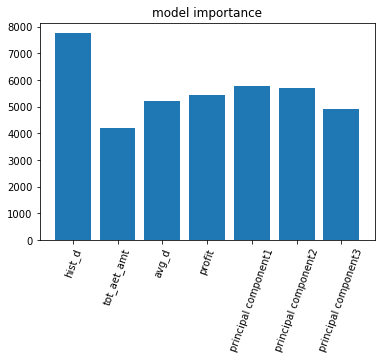

In [103]:
plt.bar(col,imp)
plt.title("model importance")
plt.xticks(rotation=70)
plt.show()

다음의 결과를 통해 validation data의 RMSE의 값은 21.xx정도가 나옴을 알 수 있습니다. valid_data를 기준으로 early stop을 하였으므로 약간의 과적합은 있을 수 있는 값입니다.
분류 모델에서는 0을 제외한 1,2,3,은 분류가 잘 안되었다고 생각할 수 있지만, 1에서 3으로 갈수록 가중치가 더욱 커지는 것을 감안하면 전체적으로 가중치가 적절히 더해지는 것을 확인하실 수 있습니다.(ex. 1로 예측한 경우를 보시면 0으로 예측한 것보다 1,2,3으로 예측한 값이 월등히 많기에 잘 분류가 되었다고 생각할 수 있습니다.

In [138]:
#실제 테스트 데이터 예측

pred=model.predict(test_data)


pred_cla=model_cla.predict(test_data_cla)


In [139]:
#전체적으로 가중치를 더해줄 값 (위에서 언급하였듯이 데이터 분포가 다르기에 편향을 비슷하게 해주고자 다음의 값을 더해줍니다.)

high_avg-avg1

22.400487855779957

In [140]:
#분류모델의 결과값에 따라 가중치를 주는데, 기본적으로 전체 예측치에 high_avg-avg1을 더해주는 과정입니다.
#이유는 위에서 제시했듯이 테스트데이터의 모델 자체의 hist_d의 평균이 트레인데이터의 hist_d의 평균치와 다름에 따라 hold_d의 분포 역시 다를 가능성이 높기에
#편향을 비슷하게 하기 위해 high_avg-avg1을 더해주는 것 입니다. (high_avg의 경우 hist_d가 평균적으로 110일때의 hold_d의 평균값 
# avg1의 경우 train시킨 hold_d의 평균값)

new_data_list=[]

for index,i in enumerate(pred_cla):
    
    
    if i==3:
        new_data_list.append(high_avg-avg1+40) 
    elif i==2:
        new_data_list.append(high_avg-avg1+30) 
    elif i==1:
        new_data_list.append(high_avg-avg1+25) 
    elif i==0:
        new_data_list.append(high_avg-avg1) 
        #10을 처음부터 추가적으로 더해주는 이유는 20년까지의 데이터보다 21년치의 데이터까지 범위를 확장해준 것을 반영하기 위함입니다.
        #관측 데이터의 범위가 길어질수록 hold_d의 평균치는 자명히 높아질 것입니다.

pred_cla=np.array(new_data_list)
print(len(pred),len(pred_cla))

70596 70596


In [141]:
#가중치를 기존 회귀값에 더해주는 과정
pred=pred_cla+pred

In [142]:
# 최대 최소값을 관찰해보았습니다.

print(max(pred))
print(min(pred))

151.8834392007903
29.27171076277256


In [143]:
#이상치 조정해주는 과정
k=[]
for i in pred:
    if i<0:
        k.append(0)

    elif i>146:
        k.append(146)
        
    else:
        k.append(i)
pred=np.array(k)

In [144]:
print(max(pred))
print(min(pred))
print(np.average(pred))

146.0
29.27171076277256
76.89263923920423


<function matplotlib.pyplot.show(close=None, block=None)>

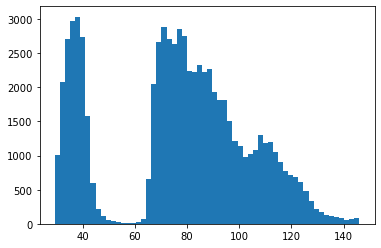

In [145]:
plt.hist(pred,bins=60)
plt.show

In [146]:
#값을 넣어줘서 저장을 하기위한 과정
submission["hold_d"]=pred

print(submission.max())
print(submission.min())

submission["hold_d"]=pred+test_hist_d

#저장하는 코드
submission.to_csv("test_file.csv", index = False)

submit_id    IDX70596
hold_d          146.0
dtype: object
submit_id     IDX00001
hold_d       29.271711
dtype: object
